# Basic statistics of images

### Import libraries

In [1]:
import pathlib

import numpy as np
import pandas as pd
from PIL import Image
import cv2
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("talk", font_scale=1.0, rc={"font.family": "serif", "font.serif": ["Computer Modern Serif"]})
import warnings
warnings.filterwarnings('ignore')


In [2]:
image_input_path = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/soiling_dataset/All/rgbImages")
fig_size = (10,6)

### Get histograms of images

In [3]:
def update_histogram(img_):
    np_hist = np.zeros((256,3))
    # For each channel calculate histogram.
    for channel in range(3):
        np_hist[:,channel] = cv2.calcHist([img_],[channel],None,[256],[0,256]).reshape(-1)
    return np_hist

In [4]:
def get_color_stats(np_hist_):
    output_dict = {}
    for channel, channel_name in zip(range(3), ["blue", "green", "red"]):
        # Convert chanel series into pandas array
        df = pd.DataFrame(np_hist_[:,channel]).reset_index()
        df.rename(columns={"index":"color_index",0:"counts"}, inplace = True)
        # Shift color indexes
        df["color_index"] +=1
        # Calculate mean on RGB scale
        df["multiplication"] = df["color_index"] * df["counts"]
        mean = df["multiplication"].sum() / df["counts"].sum()
        # Calculate standard deviation on RGB scale
        std = ((((df["color_index"]-mean)**2)*df["multiplication"]).sum()/df["multiplication"].sum())**(1/2)
        # Add it into dict
        output_dict[f"{channel_name}_mean"] = mean
        output_dict[f"{channel_name}_std"] = std
    return output_dict

In [5]:
np_hist = np.zeros((256,3))
all_stats_records = []
for file_id , file in tqdm.tqdm(enumerate(image_input_path.rglob("*.png"))):
    img = cv2.imread(str(file), cv2.IMREAD_COLOR) #returns BGR (Blue-Green-Red)
    np_hist += update_histogram(img)
    color_stats_record = get_color_stats(np_hist)
    color_stats_record["filename"] = file.stem
    color_stats_record["histogram"] = np_hist
    all_stats_records.append(color_stats_record)

5000it [02:07, 39.35it/s]


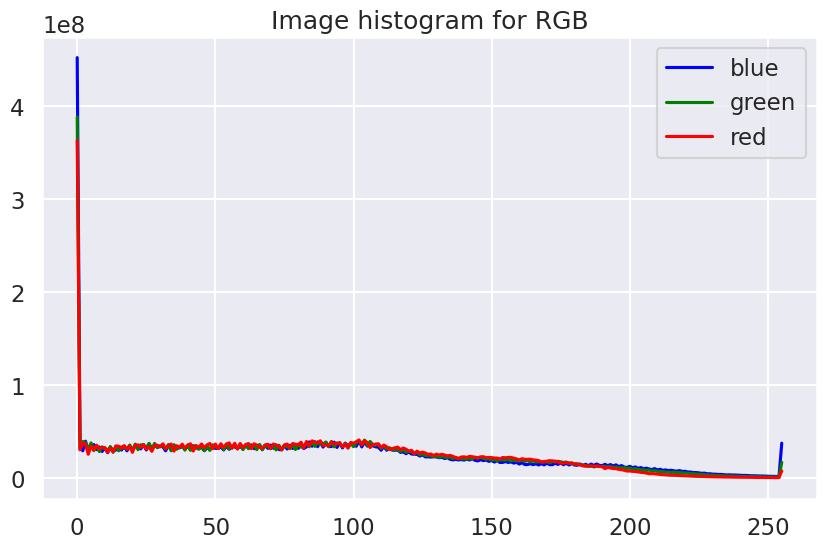

In [6]:
plt.figure(figsize =fig_size)
for channel, channel_name in zip(range(3), ["blue", "green", "red"]):
    plt.plot(np_hist[:,channel], label=channel_name, color = channel_name)
plt.title('Image histogram for RGB')
plt.legend()
plt.show()

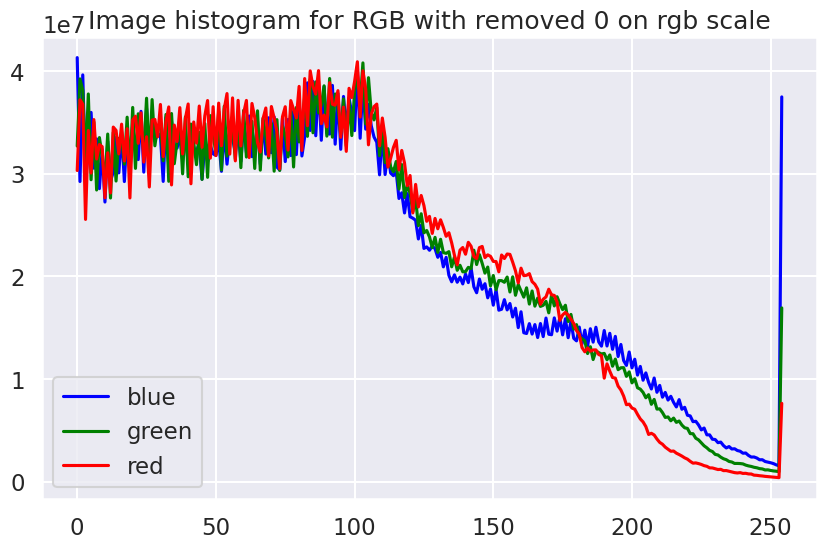

In [7]:
plt.figure(figsize =fig_size)
for channel, channel_name in zip(range(3), ["blue", "green", "red"]):
    plt.plot(np_hist[1:,channel], label=channel_name, color = channel_name)
plt.title('Image histogram for RGB with removed 0 on rgb scale')
plt.legend()
plt.show()

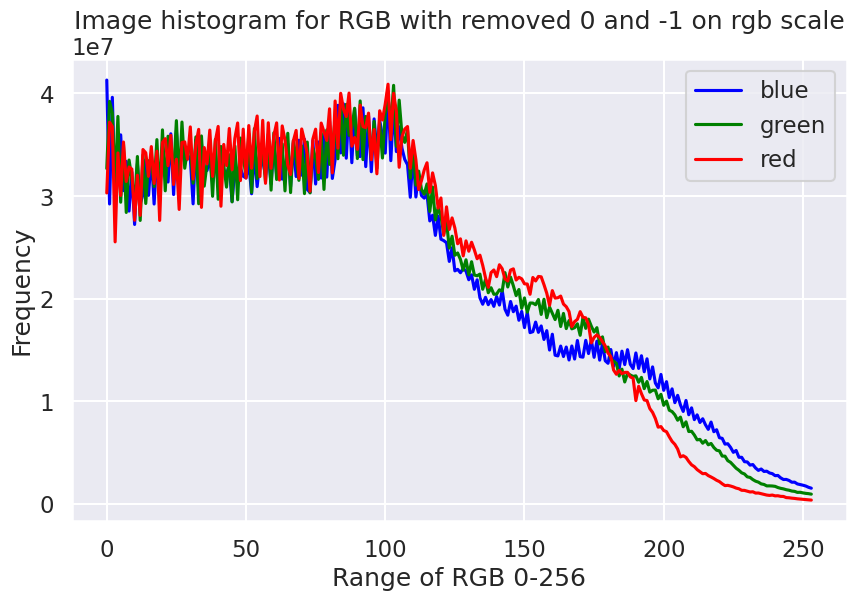

In [8]:
plt.figure(figsize =fig_size)
for channel, channel_name in zip(range(3), ["blue", "green", "red"]):
    plt.plot(np_hist[1:-1,channel], label=channel_name, color = channel_name)
plt.title('Image histogram for RGB with removed 0 and -1 on rgb scale')
plt.xlabel("Range of RGB 0-256")
plt.ylabel("Frequency")
plt.legend()
plt.show()

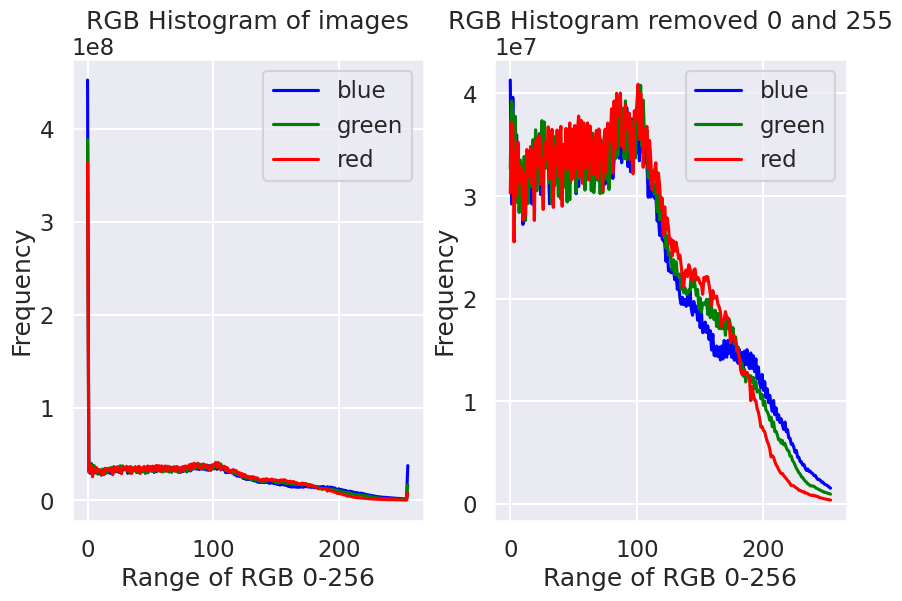

In [13]:
fig, ax = plt.subplots(1,2,figsize =fig_size)
for channel, channel_name in zip(range(3), ["blue", "green", "red"]):
    ax[0].plot(np_hist[:,channel], label=channel_name, color = channel_name)
#ax[0].title('Image histogram for RGB')
#ax[0].set_title("test")
ax[0].set_xlabel("Range of RGB 0-256")
ax[0].set_ylabel("Frequency")
ax[0].set_title('RGB Histogram of images') 
ax[0].legend()
for channel, channel_name in zip(range(3), ["blue", "green", "red"]):
    ax[1].plot(np_hist[1:-1,channel], label=channel_name, color = channel_name)
ax[1].set_xlabel("Range of RGB 0-256")
ax[1].set_ylabel("Frequency")
ax[1].set_title('RGB Histogram removed 0 and 255') 
ax[1].legend()
plt.savefig("color_histogram.png")
plt.show()

### Get statistics of labels

In [14]:
labels_input_path = pathlib.Path(r"/home/fberanek/Desktop/datasets/segmentation/semantic/soiling_dataset/All/gtLabels")

In [15]:
np_hist = np.zeros((256,3))
# Dataframe of overall stats
df = pd.DataFrame({
"Label ID":[0,1,2,3],
"Label name":["Clear", "Transparent", "Semi_transparent", "Opaque"],
"Label pixel number":[0,0,0,0]
})
# Dataframe for image stats
df_per_image = pd.DataFrame(columns= ["Filename", "Clear", "Transparent", "Semi_transparent", "Opaque"])
for file_id , file in tqdm.tqdm(enumerate(labels_input_path.rglob("*.png"))):
    lbl = np.array(Image.open(file)) #returns BGR (Blue-Green-Red)
    values, counts = np.unique(lbl, return_counts=True)
    clear = 0
    transparent = 0
    semitransparent = 0
    opaque = 0
    for value, count in zip(values, counts):
        df.loc[df["Label ID"]==value,"Label pixel number"] += count
        if value == 0:
            clear = count
        elif value == 1:
            transparent = count
        elif value == 2:
            semitransparent = count
        elif value == 3:
            opaque = count
    one_record = pd.DataFrame.from_dict([{
            "Filename":file.stem,
            "Clear":clear, 
            "Transparent":transparent, 
            "Semi_transparent":semitransparent, 
            "Opaque":opaque
        }])
    df_per_image = pd.concat([df_per_image, one_record])

5000it [01:01, 80.72it/s]


In [16]:
df_per_image.set_index("Filename", inplace=True)
df_per_image["Total_number_of_pixel"] = df_per_image.sum(axis = 1)

We are processing occlusion level of Clear
Distribution of occlusion level Clear is Clear_relative
(0.0, 0.1]                                  1349
(0.9, 1.0]                                   707
(0.1, 0.2]                                   459
(0.8, 0.9]                                   417
(0.6000000000000001, 0.7000000000000001]     357
(0.5, 0.6000000000000001]                    317
(0.30000000000000004, 0.4]                   304
(0.2, 0.30000000000000004]                   283
(0.4, 0.5]                                   215
(0.7000000000000001, 0.8]                    173
Name: count, dtype: int64


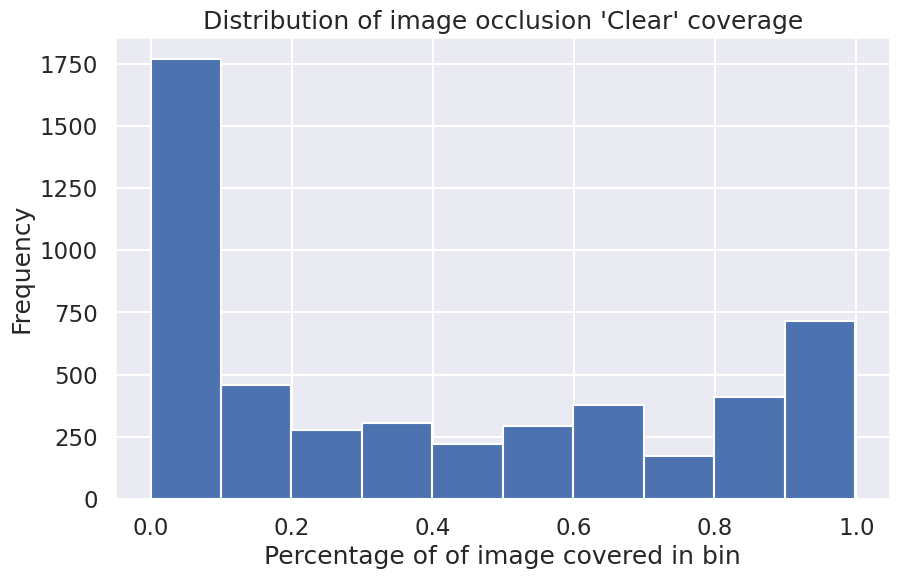

We are processing occlusion level of Transparent
Distribution of occlusion level Transparent is Clear_relative
(0.0, 0.1]                                  1349
(0.9, 1.0]                                   707
(0.1, 0.2]                                   459
(0.8, 0.9]                                   417
(0.6000000000000001, 0.7000000000000001]     357
(0.5, 0.6000000000000001]                    317
(0.30000000000000004, 0.4]                   304
(0.2, 0.30000000000000004]                   283
(0.4, 0.5]                                   215
(0.7000000000000001, 0.8]                    173
Name: count, dtype: int64


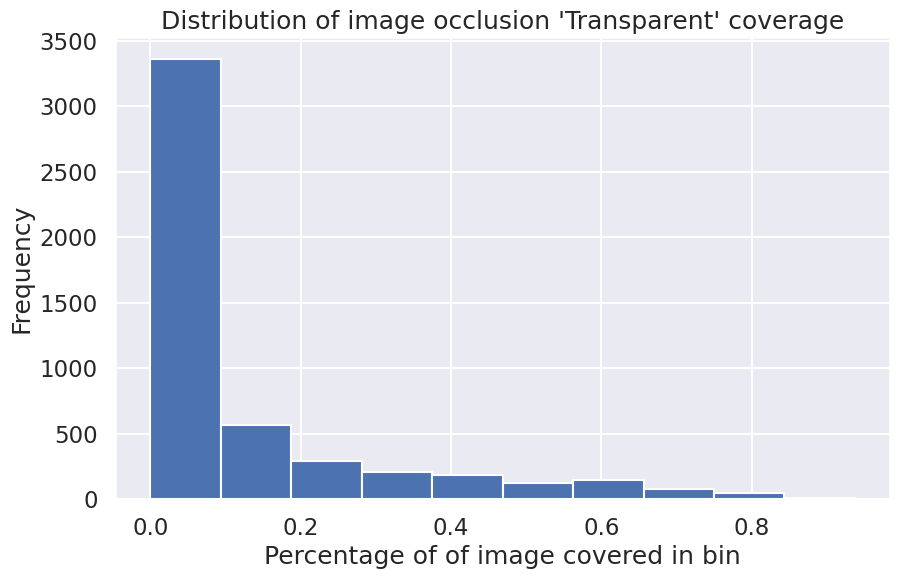

We are processing occlusion level of Semi_transparent
Distribution of occlusion level Semi_transparent is Clear_relative
(0.0, 0.1]                                  1349
(0.9, 1.0]                                   707
(0.1, 0.2]                                   459
(0.8, 0.9]                                   417
(0.6000000000000001, 0.7000000000000001]     357
(0.5, 0.6000000000000001]                    317
(0.30000000000000004, 0.4]                   304
(0.2, 0.30000000000000004]                   283
(0.4, 0.5]                                   215
(0.7000000000000001, 0.8]                    173
Name: count, dtype: int64


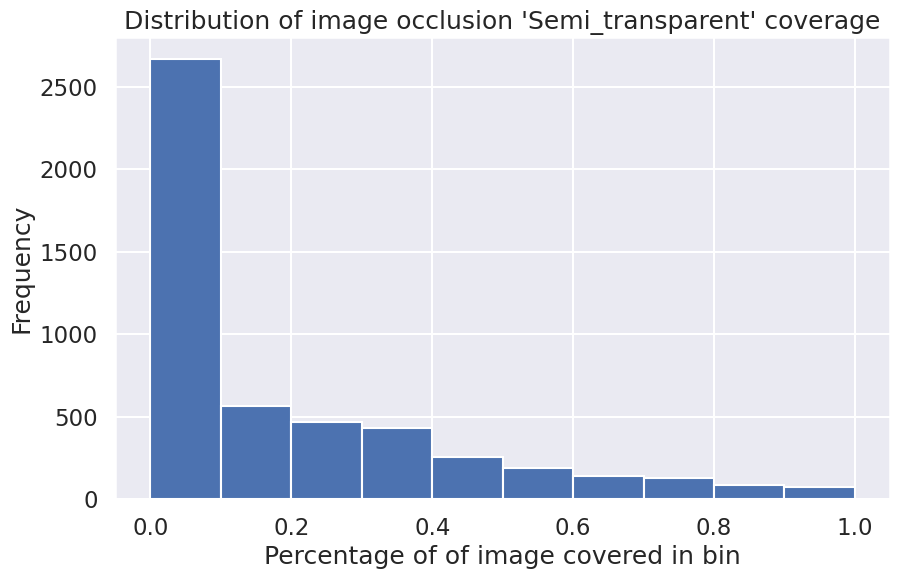

We are processing occlusion level of Opaque
Distribution of occlusion level Opaque is Clear_relative
(0.0, 0.1]                                  1349
(0.9, 1.0]                                   707
(0.1, 0.2]                                   459
(0.8, 0.9]                                   417
(0.6000000000000001, 0.7000000000000001]     357
(0.5, 0.6000000000000001]                    317
(0.30000000000000004, 0.4]                   304
(0.2, 0.30000000000000004]                   283
(0.4, 0.5]                                   215
(0.7000000000000001, 0.8]                    173
Name: count, dtype: int64


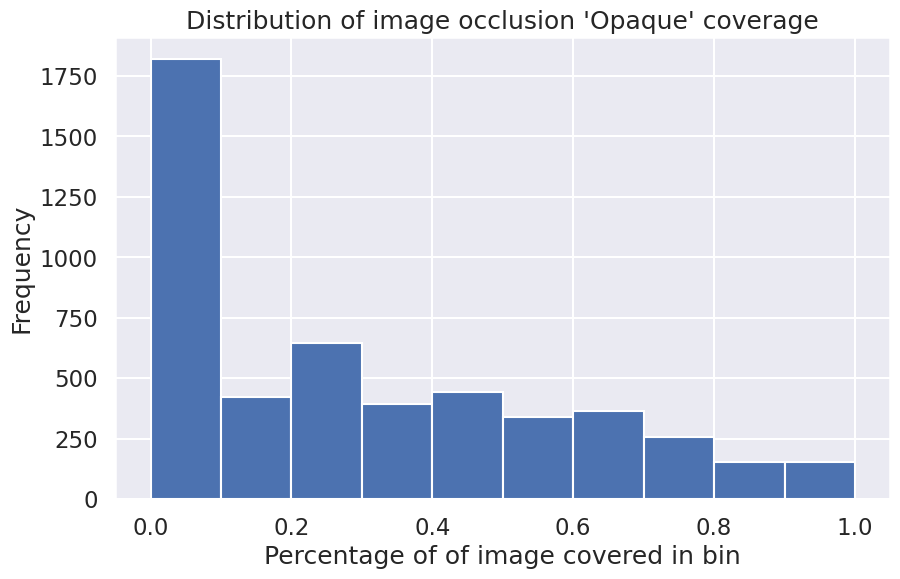

In [17]:
list_of_column_names = ["Clear", "Transparent", "Semi_transparent", "Opaque"]
for column in list_of_column_names:
    print(f"We are processing occlusion level of {column}")
    df_per_image[f"{column}_relative"] = df_per_image[column]/df_per_image["Total_number_of_pixel"]
    bins = pd.interval_range(0,1,10)
    distribution = pd.cut(df_per_image['Clear_relative'], bins).value_counts()
    print(f"Distribution of occlusion level {column} is {distribution}")
    plt.figure(figsize=fig_size)
    plt.hist(df_per_image[f"{column}_relative"])
    plt.xlabel("Percentage of of image covered in bin")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of image occlusion '{column}' coverage")
    plt.show()

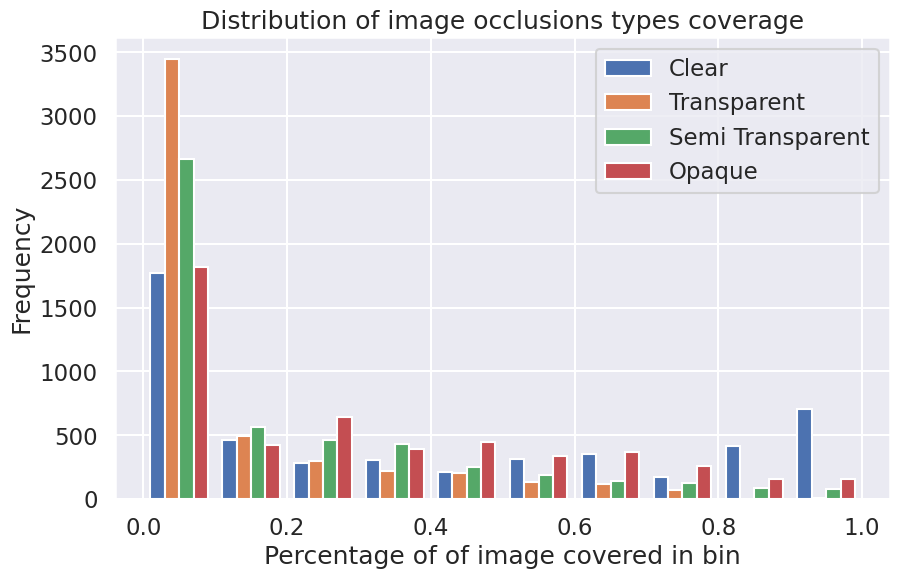

In [18]:
list_of_column_names = ["Clear", "Transparent", "Semi_transparent", "Opaque"]
plt.figure(figsize=fig_size)
plt.hist([df_per_image["Clear_relative"], 
          df_per_image["Transparent_relative"],
          df_per_image["Semi_transparent_relative"], 
          df_per_image["Opaque_relative"]], label = [
              "Clear", 
               "Transparent", 
               "Semi Transparent", 
               "Opaque"
          ])
plt.xlabel("Percentage of of image covered in bin")
plt.ylabel("Frequency")
plt.title(f"Distribution of image occlusions types coverage")
plt.legend()
plt.savefig("labels_distribution")
plt.show()

In [19]:
list_of_occlusion_column_names = ["Transparent", "Semi_transparent", "Opaque"]

In [20]:
df_per_image["total_occlusion"] = df_per_image[list_of_occlusion_column_names].sum(axis=1)
df_per_image["total_occlusion_ration"] = df_per_image["total_occlusion"] / df_per_image["Total_number_of_pixel"]

In [21]:
df_per_image

,Clear,Transparent,Semi_transparent,Opaque,Total_number_of_pixel,Clear_relative,Transparent_relative,Semi_transparent_relative,Opaque_relative,total_occlusion,total_occlusion_ration
Filename,,,,,,,,,,,
0207_MVR,265260,963540,0,0,1228800,0.215869,0.784131,0.0,0.0,963540,0.784131
3607_MVL,271731,90316,47119,819634,1228800,0.221135,0.073499,0.038346,0.66702,957069,0.778865
2672_FV,1439,445001,782360,0,1228800,0.001171,0.362143,0.636686,0.0,1227361,0.998829
1111_MVR,1102849,0,48217,77734,1228800,0.897501,0.0,0.039239,0.06326,125951,0.102499
4247_MVR,0,0,545754,683046,1228800,0.0,0.0,0.444136,0.555864,1228800,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3401_FV,717348,117284,30733,363435,1228800,0.583779,0.095446,0.025011,0.295764,511452,0.416221
0213_MVR,265260,963540,0,0,1228800,0.215869,0.784131,0.0,0.0,963540,0.784131
2065_MVR,361470,0,474527,392803,1228800,0.294165,0.0,0.386171,0.319664,867330,0.705835


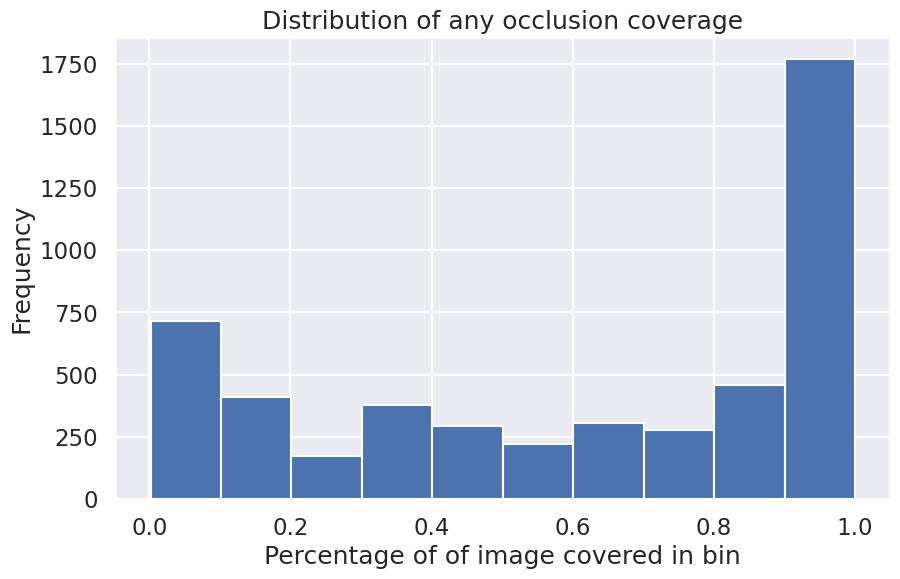

In [24]:
plt.figure(figsize=fig_size)
plt.hist(df_per_image["total_occlusion_ration"])
plt.xlabel("Percentage of of image covered in bin")
plt.ylabel("Frequency")
plt.title(f"Distribution of any occlusion coverage")
plt.savefig("distribution_of_oclusion.png")
plt.show()